In [66]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, optimization_visualization_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
importlib.reload(optimization_visualization_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint, set_design_parameters_from_topology, get_max_distance_to_target_surface, write_distance_to_linkage_mesh, get_fixed_boundary_joint)
import vis.fields
import matplotlib.cm as cm
import time
from optimization_visualization_helper import (compute_visualization_data_from_raw_data, get_objective_components_stage1, get_objective_components_stage2, get_objective_components_stage3, set_figure_label_and_limit, Visualization_Setting, plot_objective, plot_ribbon_component_analysis)

In [5]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [6]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.1
dsw = 0.1

In [7]:
import pickle 
import gzip
# pickle.dump(curved_linkage, gzip.open('hemoglobin_test_20201202.pkl.gz', 'w'))
# pickle.load(gzip.open('hemoglobin_three_stages_results/hemoglobin_contact_opt_2020_1201.pkl.gz', 'r'))

In [22]:
import numpy as np 
from numpy import linalg as la

linkage_file = weaving_dir + 'models/{}.obj'
surface_file = weaving_dir + 'surface_models/{}.obj'

output_linkage_file = weaving_dir + 'normalized_objs/models/{}.obj'
output_surface_file = weaving_dir + 'normalized_objs/surface_models/{}.obj'
def get_input_data(zscale):
    def scale_model(target_size, linkage_file, surface_file, output_linkage_file, output_surface_file):
        point_list = []
        edge_list = []
        face_list = []
        with open(linkage_file, 'r') as linkage, open(output_linkage_file, 'w') as output_linkage, open(surface_file, 'r') as surface, open(output_surface_file, 'w') as output_surface:
            content = linkage.readlines()
            count = 0
            edge_count = 0
            for line in content:
                if 'v ' in line:
                    point = np.array([float(x) for x in line.split(' ')[1:]])
                    point_list.append(point)

                if 'l ' in line:
                    edge_list.append(line)

                if 'f ' in line:
                    face_list.append(line)

            cm = np.sum(np.array(point_list), axis = 0) / len(point_list)

            centered_point_list = []
            point_norm = []
            for point in point_list:
                point = np.array(point) - cm
                centered_point_list.append(point)
                point_norm.append(la.norm(point))

            scale = target_size / max(point_norm)
            print(scale, cm)

            for line in content:
                if 'v ' in line:
                    point = np.array([float(x) for x in line.split(' ')[1:]])
                    point = scale * (point - cm)
                    output_linkage.write('v {} {} {}\n'.format(point[0], point[1], point[2] * zscale))
                else:
                    output_linkage.write(line)

            surface_content = surface.readlines()
            for line in surface_content:
                if 'v ' in line:
                    point = np.array([float(x) for x in line.split(' ')[1:]])
                    point = scale * (point - cm)
                    output_surface.write('v {} {} {}\n'.format(point[0], point[1], point[2] * zscale))
                else:
                    output_surface.write(line)

    linkage_name_list = ['simple_hemoglobin_5']
    surface_name_list = linkage_name_list
    target_size = 1
    for linkage_name, surface_name in zip(linkage_name_list, surface_name_list):
        scale_model(target_size, linkage_file.format(linkage_name), surface_file.format(surface_name), output_linkage_file.format(linkage_name+'_{}'.format(str(target_size) + '_z{}'.format(zscale))), output_surface_file.format(surface_name+'_{}'.format(str(target_size) + '_z{}'.format(zscale))))


In [23]:
np.arange(0.25, 3.75, 0.1)

array([0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25,
       1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15, 2.25, 2.35,
       2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15, 3.25, 3.35, 3.45,
       3.55, 3.65])

In [129]:
data = []

In [130]:
def render_stress(filename, rangeMin = None, rangeMax = None):
    import vis
    from matplotlib import cm

    stress = np.array(curved_linkage.maxBendingStresses())
#     stress = curved_linkage.twistingStresses()
#     for i in range(len(stress)):
#         if i not in seg_list:
#             stress[i] *= 0
    if rangeMin == None:
        rangeMin = np.stack(stress).min()
    if rangeMax == None:
        rangeMax = np.stack(stress).max()
    print(rangeMin, rangeMax)
    print(np.stack(stress).min(), np.stack(stress).max())
    sf = vis.fields.ScalarField(curved_linkage, stress, colormap=cm.plasma, vmin=rangeMin, vmax=rangeMax)
    heights = curved_linkage.visualizationGeometryHeightColors()
    colors = sf.colors()
    
    # colors[heights < heights.mean()] = np.ones_like(sf.colors()[heights < heights.mean()]) * 0.5
    curved_linkage_view.update(scalarField = colors)

    renderCam = np.load('../../../hemoglobin_stress_renderCam.npy')
    def renderToFile(path):
        orender = curved_linkage_view.offscreenRenderer(width=2048, height=2048)
        orender.setCameraParams(renderCam)
        orender.render()
        orender.save(path)
    renderToFile(filename)

In [133]:
data_root = './'
for scale in np.arange(0.2, 5, 0.1):
    scale = np.round(scale, 3)
    print('Current scale: ', scale)
#     if os.path.exists('{}/manual_{}.png'.format(data_root, scale)):
#         continue
    io = InputOrganizer('simple_hemoglobin_5_1{}'.format('_z{}'.format(scale)), thickness, width, weaving_dir)
    get_input_data(scale)
    if scale > 3:    
        with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, interleaving_type = InterleavingType.weaving)
        input_joint_normals = np.reshape(curved_linkage.get_closest_point_normal(curved_linkage.jointPositions()), (curved_linkage.numJoints(), 3))
#         current_joint_normals = [curved_linkage.joint(i).normal for i in range(curved_linkage.numJoints())]
#         current_joint_normals[35] = input_joint_normals[35]
        with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.triaxialWeave, input_joint_normals = input_joint_normals)
    else:
        with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
    curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
    curved_save_tgt_joint_pos = curved_linkage.jointPositions();
    print('start rest length: ', curved_linkage.totalRestLength())
    start_length = curved_linkage.totalRestLength()

    set_design_parameters_from_topology(curved_linkage, io)
    # iterateData = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view)
    def eqm_callback(prob, i):
        pass
    OPTS.gradTol = 1e-10
    curved_linkage.attraction_weight = 1e-5
    with so(): elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = curved_linkage.restLenFixedVars())
    close_to_surface_bend_gradNorm = la.norm(curved_linkage.gradientBend())
    close_to_surface_twist_gradNorm = la.norm(curved_linkage.gradientTwist())
    close_to_surface_stretch_gradNorm = la.norm(curved_linkage.gradientStretch())
    
    curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)

    render_stress('{}/manual_stress_{}.png'.format(data_root, scale), rangeMin = None, rangeMax = None)
    
    renderCam = np.load('../../../hemoglobin_stress_renderCam.npy')
    def renderToFile(view, renderCam, path):
        orender = view.offscreenRenderer(width=2048, height=2048)
        orender.setCameraParams(renderCam)
        orender.render()
        orender.save(path)

    distance_color = write_distance_to_linkage_mesh(curved_linkage, 0.08, None, return_distance_field = True)
    curved_linkage_view.update(scalarField = distance_color[:, :3])
    renderToFile(curved_linkage_view, renderCam, '{}/close_{}.png'.format(data_root, scale))
    
    with so(): elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    # curved_linkage_view.update()
    distance_to_target_initialization = np.round(get_max_distance_to_target_surface(curved_linkage) / curved_linkage.get_l0(), 4)
    print('after initialization rest length: ', curved_linkage.totalRestLength())
    print('distance_to_target_initialization: ', distance_to_target_initialization)
    end_length = curved_linkage.totalRestLength()
    dis = distance_to_target_initialization
    end_surface_bend_gradNorm = la.norm(curved_linkage.gradientBend())
    end_surface_twist_gradNorm = la.norm(curved_linkage.gradientTwist())
    end_surface_stretch_gradNorm = la.norm(curved_linkage.gradientStretch())
    
    data.append([start_length, end_length, dis, close_to_surface_bend_gradNorm, close_to_surface_twist_gradNorm, close_to_surface_stretch_gradNorm, end_surface_bend_gradNorm, end_surface_twist_gradNorm, end_surface_stretch_gradNorm])
    
    curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
#     renderCam = curved_linkage_view.getCameraParams()
#     np.save('{}_renderCam.npy'.format(name), renderCam)
    renderCam = np.load('../../../hemoglobin_stress_renderCam.npy')
    def renderToFile(view, renderCam, path):
        orender = view.offscreenRenderer(width=2048, height=2048)
        orender.setCameraParams(renderCam)
        orender.render()
        orender.save(path)

    distance_color = write_distance_to_linkage_mesh(curved_linkage, 0.08, None, return_distance_field = True)
    curved_linkage_view.update(scalarField = distance_color[:, :3])
    renderToFile(curved_linkage_view, renderCam, '{}/manual_{}.png'.format(data_root, scale))

Current scale:  0.2
0.17088398618318584 [-0.3996742  80.14140386  3.61524935]
start rest length:  47.002563134906424
0.0286069076888854 215.20176794326144
0.0286069076888854 215.20176794326144
after initialization rest length:  47.100440609194756
distance_to_target_initialization:  0.058
Current scale:  0.3
0.17088398618318584 [-0.3996742  80.14140386  3.61524935]
start rest length:  47.2263031102075
0.018367550488885928 177.98678660920504
0.018367550488885928 177.98678660920504
after initialization rest length:  47.35197325506082
distance_to_target_initialization:  0.0615
Current scale:  0.4
0.17088398618318584 [-0.3996742  80.14140386  3.61524935]
start rest length:  47.5329900912079
0.01619382068800268 136.85248841282905
0.01619382068800268 136.85248841282905
after initialization rest length:  47.68379509771478
distance_to_target_initialization:  0.0326
Current scale:  0.5
0.17088398618318584 [-0.3996742  80.14140386  3.61524935]
start rest length:  47.917075993919845
0.005144303424

Exception ignored in: <function PythreejsViewerBase.__del__ at 0x118512680>
Traceback (most recent call last):
  File "/Users/yren/Develop/EPFL_LGG/weaving/elastic_rods/3rdparty/MeshFEM/python/vis/pythreejs_viewer.py", line 553, in __del__
    self.__cleanMeshes(self.ghostMeshes)
AttributeError: 'LinkageViewerWithSurface' object has no attribute 'ghostMeshes'


Current scale:  2.4
0.17088398618318584 [-0.3996742  80.14140386  3.61524935]
start rest length:  63.62707598356456
0.05627402583088466 80.5390087364222
0.05627402583088466 80.5390087364222
after initialization rest length:  64.22275057356927
distance_to_target_initialization:  0.0339
Current scale:  2.5
0.17088398618318584 [-0.3996742  80.14140386  3.61524935]
start rest length:  64.69542800940062
0.02094898537912722 83.50749256682717
0.02094898537912722 83.50749256682717
after initialization rest length:  65.31246115445538
distance_to_target_initialization:  0.0349
Current scale:  2.6
0.17088398618318584 [-0.3996742  80.14140386  3.61524935]
start rest length:  65.77703250389311
0.05939542272620474 86.41811940365403
0.05939542272620474 86.41811940365403
after initialization rest length:  66.41497185732922
distance_to_target_initialization:  0.0357
Current scale:  2.7
0.17088398618318584 [-0.3996742  80.14140386  3.61524935]
start rest length:  66.87106382547353
0.11342568524360372 89

In [82]:
curved_linkage.energy()

0.0003585270479223348

In [83]:
curved_linkage.energyBend()

0.00027971263968734383

In [17]:
curved_linkage.gradientTwist()

array([ 4.43930917e-07, -2.82784037e-07, -3.22068444e-07, ...,
       -7.54497638e-08, -4.06046366e-07,  1.91185269e-07])

In [16]:
curved_linkage.gradientStretch()

array([ 5.35967485e-03,  7.92330213e-03,  9.56648675e-04, ...,
        9.29865526e-06, -2.72728534e-02, -3.04261052e-02])

In [15]:
curved_linkage.gradientBend()

array([-0.23302828,  0.16610346, -0.07401327, ..., -0.00038758,
        0.0253253 ,  0.01248109])

In [89]:
# np.save('renderCam.npy', curved_linkage_view.getCameraParams())

In [136]:
data = np.array(data)

In [141]:
data[-10:, 2]

array([0.0475, 0.0481, 0.049 , 0.0495, 0.0502, 0.0511, 0.0522, 0.053 ,
       0.0537, 0.0541])

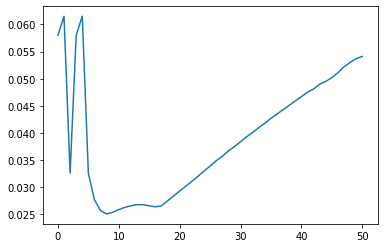

In [137]:
plt.plot(data[:, 2])
# plt.legend(['bend', 'twist', 'stretch', 'bend', 'twist', 'stretch'])

In [50]:
rod_length = 0.21162395234664752
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
# width *= 0.5
# thickness *= 0.5

io = InputOrganizer('simple_hemoglobin_5_1', thickness, width, weaving_dir)
#  [ ear 214, ear 255, nose 39]

0.0705413174488825 0.004937892221421775


In [118]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [119]:
set_design_parameters_from_topology(curved_linkage, io)

In [120]:
# iterateData = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view)

In [88]:
curved_linkage.attraction_weight = 1e-5
def eqm_callback(prob, i):
#     pass
   curved_linkage_view.update()
OPTS.gradTol = 1e-10

In [89]:
OPTS.gradTol = 1e-10

In [90]:
curved_linkage.restLenFixedVars()

In [126]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = [])
curved_linkage_view.update()

0	0.000186756	0.00294559	0.00294559	0.5	0
1	0.000180572	0.0243252	0.0243252	1	0
2	0.000174867	0.00477422	0.00477422	0.5	0
3	0.000173402	0.0102918	0.0102918	1	0
4	0.000172007	0.00496386	0.00496386	1	0
5	0.000171281	0.00768998	0.00768998	1	0
6	0.0001708	0.00266487	0.00266487	1	0
7	0.000170594	0.00365327	0.00365327	1	0
8	0.000170484	0.00141933	0.00141933	1	0
9	0.000170449	0.000559414	0.000559414	1	0
10	0.000170442	0.000639104	0.000639104	1	0
11	0.000170439	6.33818e-05	6.33818e-05	1	0
12	0.000170439	2.63148e-05	2.63148e-05	1	0
13	0.000170439	8.07696e-07	8.07696e-07	0.25	0
14	0.000170439	1.67879e-05	1.67879e-05	1	0
15	0.000170439	9.75757e-07	9.75757e-07	0.25	0
16	0.000170439	1.03866e-05	1.03866e-05	1	0
17	0.000170439	2.10962e-06	2.10962e-06	0.5	0
18	0.000170439	1.05099e-05	1.05099e-05	1	0
19	0.000170439	1.74077e-06	1.74077e-06	0.5	0
20	0.000170439	1.21553e-05	1.21553e-05	1	0
21	0.000170439	1.15609e-06	1.15609e-06	0.25	0
22	0.000170439	5.30281e-06	5.30281e-06	1	0
23	0.000170439	4.22131e-06	4

In [123]:
distance_to_target_initialization = np.round(get_max_distance_to_target_surface(curved_linkage) / curved_linkage.get_l0(), 4)

In [124]:
distance_to_target_initialization

0.0043

In [100]:
ribbons = order_segments_by_ribbons(curved_linkage)

In [106]:
seg_list = [pair[0] for pair in ribbons[2]]

In [127]:
import vis
from matplotlib import cm

# stress = np.array(curved_linkage.maxBendingStresses())
stress = curved_linkage.twistingStresses()
for i in range(len(stress)):
    if i not in seg_list:
        stress[i] *= 0
        
# rangeMin = np.stack(stress).min()
# rangeMax = np.stack(stress).max()
sf = vis.fields.ScalarField(curved_linkage, stress, colormap=cm.magma, vmin=rangeMin, vmax=rangeMax)
heights = curved_linkage.visualizationGeometryHeightColors()
colors = sf.colors()
# colors[heights < heights.mean()] = np.ones_like(sf.colors()[heights < heights.mean()]) * 0.5
curved_linkage_view.update(scalarField = colors)

renderCam = curved_linkage_view.getCameraParams()
def renderToFile(path):
    orender = curved_linkage_view.offscreenRenderer(width=2048, height=2048)
    orender.setCameraParams(renderCam)
    orender.render()
    orender.save(path)
renderToFile('hemoglobin_manual_twist.png')

In [17]:
# Visualize the stresses on a single rod before and after freeing it from the weave.
rod_stress_view = optimization_visualization_helper.freedRibbonEquilibriumVisualization(curved_linkage, 0)
rod_stress_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [20]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, inner_gradTol = 1e-7)

In [22]:
start = time.time()
optimizer, opt_iterateData, weight_change_iterations, solverStatusList = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, [], -3, 3, return_weight_change_iteration = True)
print(time.time() - start)

rl_regularization_weight 1.0
smoothing_weight 10.0
stage 2 optimization with attraction weight 100.0
Samara:  bird_1.pkl.gz
Samara:  bird_2.pkl.gz
Samara:  bird_3.pkl.gz
Samara:  bird_4.pkl.gz
Samara:  bird_5.pkl.gz
stage 2 optimization with attraction weight 0.31622776601683794
Samara:  bird_6.pkl.gz
Samara:  bird_7.pkl.gz
Samara:  bird_8.pkl.gz
Samara:  bird_9.pkl.gz
Samara:  bird_10.pkl.gz
Samara:  bird_11.pkl.gz
Samara:  bird_12.pkl.gz
Samara:  bird_13.pkl.gz
Samara:  bird_14.pkl.gz
Samara:  bird_15.pkl.gz
Samara:  bird_16.pkl.gz
Samara:  bird_17.pkl.gz
Samara:  bird_18.pkl.gz
Samara:  bird_19.pkl.gz
Samara:  bird_20.pkl.gz
Samara:  bird_21.pkl.gz
Samara:  bird_22.pkl.gz
Samara:  bird_23.pkl.gz
Samara:  bird_24.pkl.gz
Samara:  bird_25.pkl.gz
Samara:  bird_26.pkl.gz
Samara:  bird_27.pkl.gz
Samara:  bird_28.pkl.gz
Samara:  bird_29.pkl.gz
Samara:  bird_30.pkl.gz
Samara:  bird_31.pkl.gz
Samara:  bird_32.pkl.gz
Samara:  bird_33.pkl.gz
Samara:  bird_34.pkl.gz
Samara:  bird_35.pkl.gz
Sama

ValueError: too many values to unpack (expected 3)

In [116]:
renderCam = curved_linkage_view.getCameraParams()
def renderToFile(path):
    orender = curved_linkage_view.offscreenRenderer(width=2048, height=2048)
    orender.setCameraParams(renderCam)
    orender.render()
    orender.save(path)
renderToFile('hemoglobin_manual.png')

In [117]:
#         {
#             "name": "simple_hemoglobin_5_1_z4.6",
#             "display_name": "Teardrop Deep",
#             "thickness": 0.004937892221421775,
#             "width": 0.0705413174488825,
#             "constant_cross_section": true,
#             "cross_section_scale": [
#                 0,
#                 0
#             ],
#             "scale_joint_weight": "-1",
#             "update_attraction_weight": -5,
#             "number_of_updates": 3,
#             "fix_boundary": false,
#             "only_two_stage": false,
#             "num_joints": 120,
#             "num_segments": 240,
#             "num_ribbons": 12,
#             "num_sim_vars": 17640,
#             "num_design_vars": 4800
#         },